# KMeans

Based on <https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html>

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [2]:
from common.data import get_data
from common.paths import HEALTHY, ADHD

X, Y, demographics, population = get_data(label_path=ADHD)
ages, sexes = demographics['Age'], demographics['Sex']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (373, 34716) | Y: 6 | Age: (373,) | Population: adhd


In [3]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

## Determine number of clusters

In [20]:
range_n_clusters = [n for n in range(2, 10)]
X = StandardScaler().fit_transform(X)

### Silhouette Analysis

In [14]:
%%time

silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    avg_silhouette_score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(avg_silhouette_score)
    print(f'Num clusters: {n_clusters} | Silhouette score: {avg_silhouette_score:.4f}')

max_sil_index = np.argmax(silhouette_scores)
print('---')
print(f'Largest silhouette score {silhouette_scores[max_sil_index]} with {range_n_clusters[max_sil_index]} clusters')

Num clusters: 2 | Silhouette score: 0.1171
Num clusters: 3 | Silhouette score: 0.0571
Num clusters: 4 | Silhouette score: 0.0297
Num clusters: 5 | Silhouette score: 0.0171
Num clusters: 6 | Silhouette score: 0.0071
Num clusters: 7 | Silhouette score: 0.0192
Num clusters: 8 | Silhouette score: 0.0034
Num clusters: 9 | Silhouette score: 0.0037
---
Largest silhouette score 0.11708091199398041 with 2 clusters
CPU times: user 13min 16s, sys: 41.2 s, total: 13min 57s
Wall time: 1min 29s


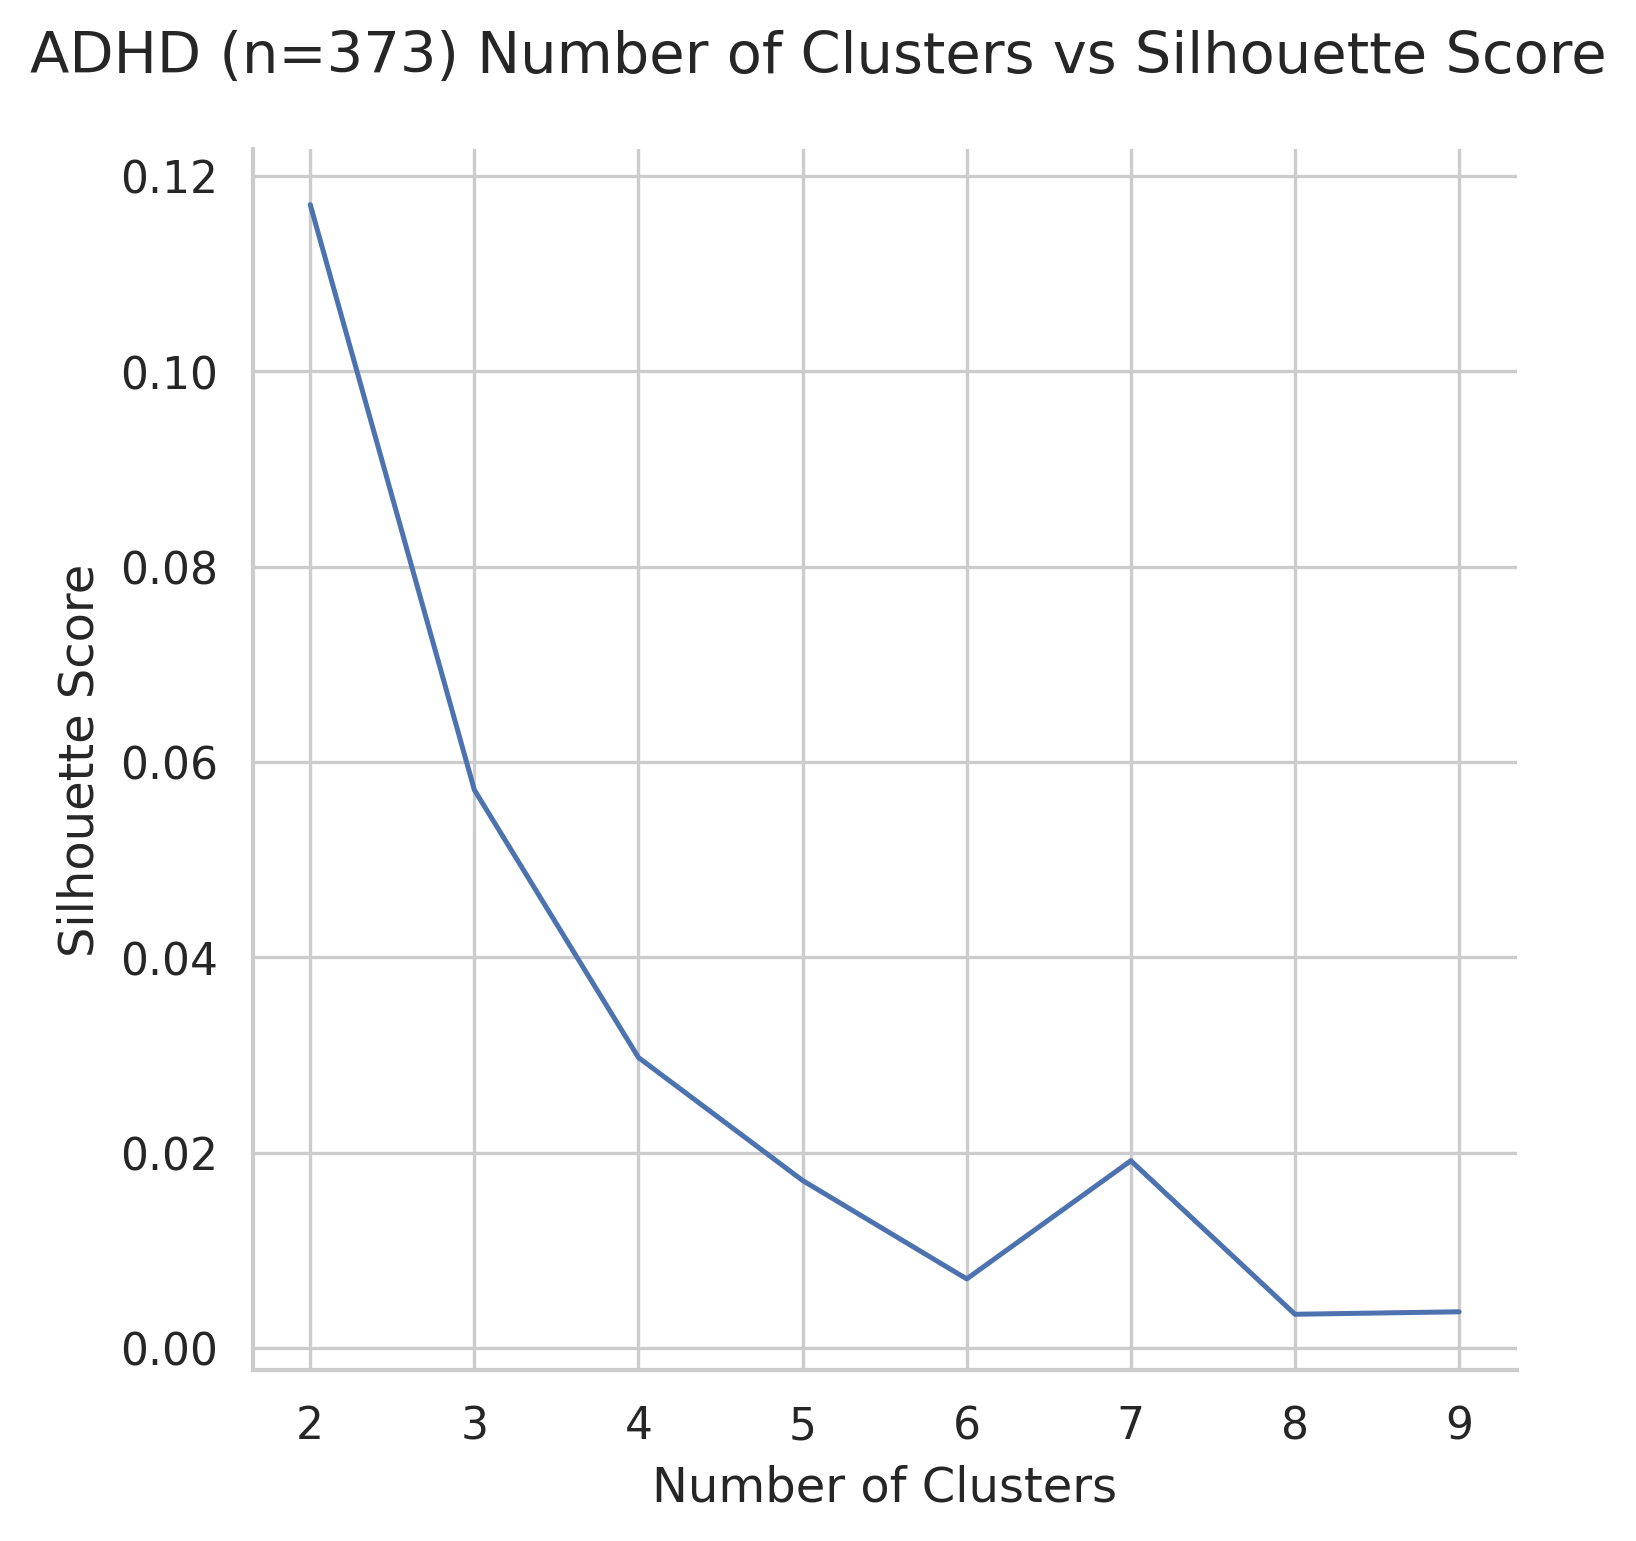

In [15]:
g = sns.relplot(x=range_n_clusters, y=silhouette_scores, kind="line")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f'ADHD (n={X.shape[0]}) Number of Clusters vs Silhouette Score')
g.set_axis_labels('Number of Clusters', 'Silhouette Score')

### Bayesian Information Criterion

In [17]:
%%time

bics = []

for n_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag', reg_covar=1e-5)
    gmm.fit(X)
    bic = gmm.bic(X)
    bics.append(bic)
    print(f'Num clusters: {n_clusters} | BIC: {bic:.2f}')

min_bic_index = np.argmin(bics)
print('---')
print(f'Smallest BIC {bics[min_bic_index]} with {range_n_clusters[min_bic_index]} clusters')

Num clusters: 2 | BIC: 35516822.41
Num clusters: 3 | BIC: 35151110.59
Num clusters: 4 | BIC: 35002616.40
Num clusters: 5 | BIC: 35280269.71
Num clusters: 6 | BIC: 35526656.92
Num clusters: 7 | BIC: 35742988.85
Num clusters: 8 | BIC: 35939913.72
Num clusters: 9 | BIC: 35759025.07
---
Smallest BIC 35002616.400843374 with 4 clusters
CPU times: user 5min 39s, sys: 29 s, total: 6min 8s
Wall time: 43.1 s


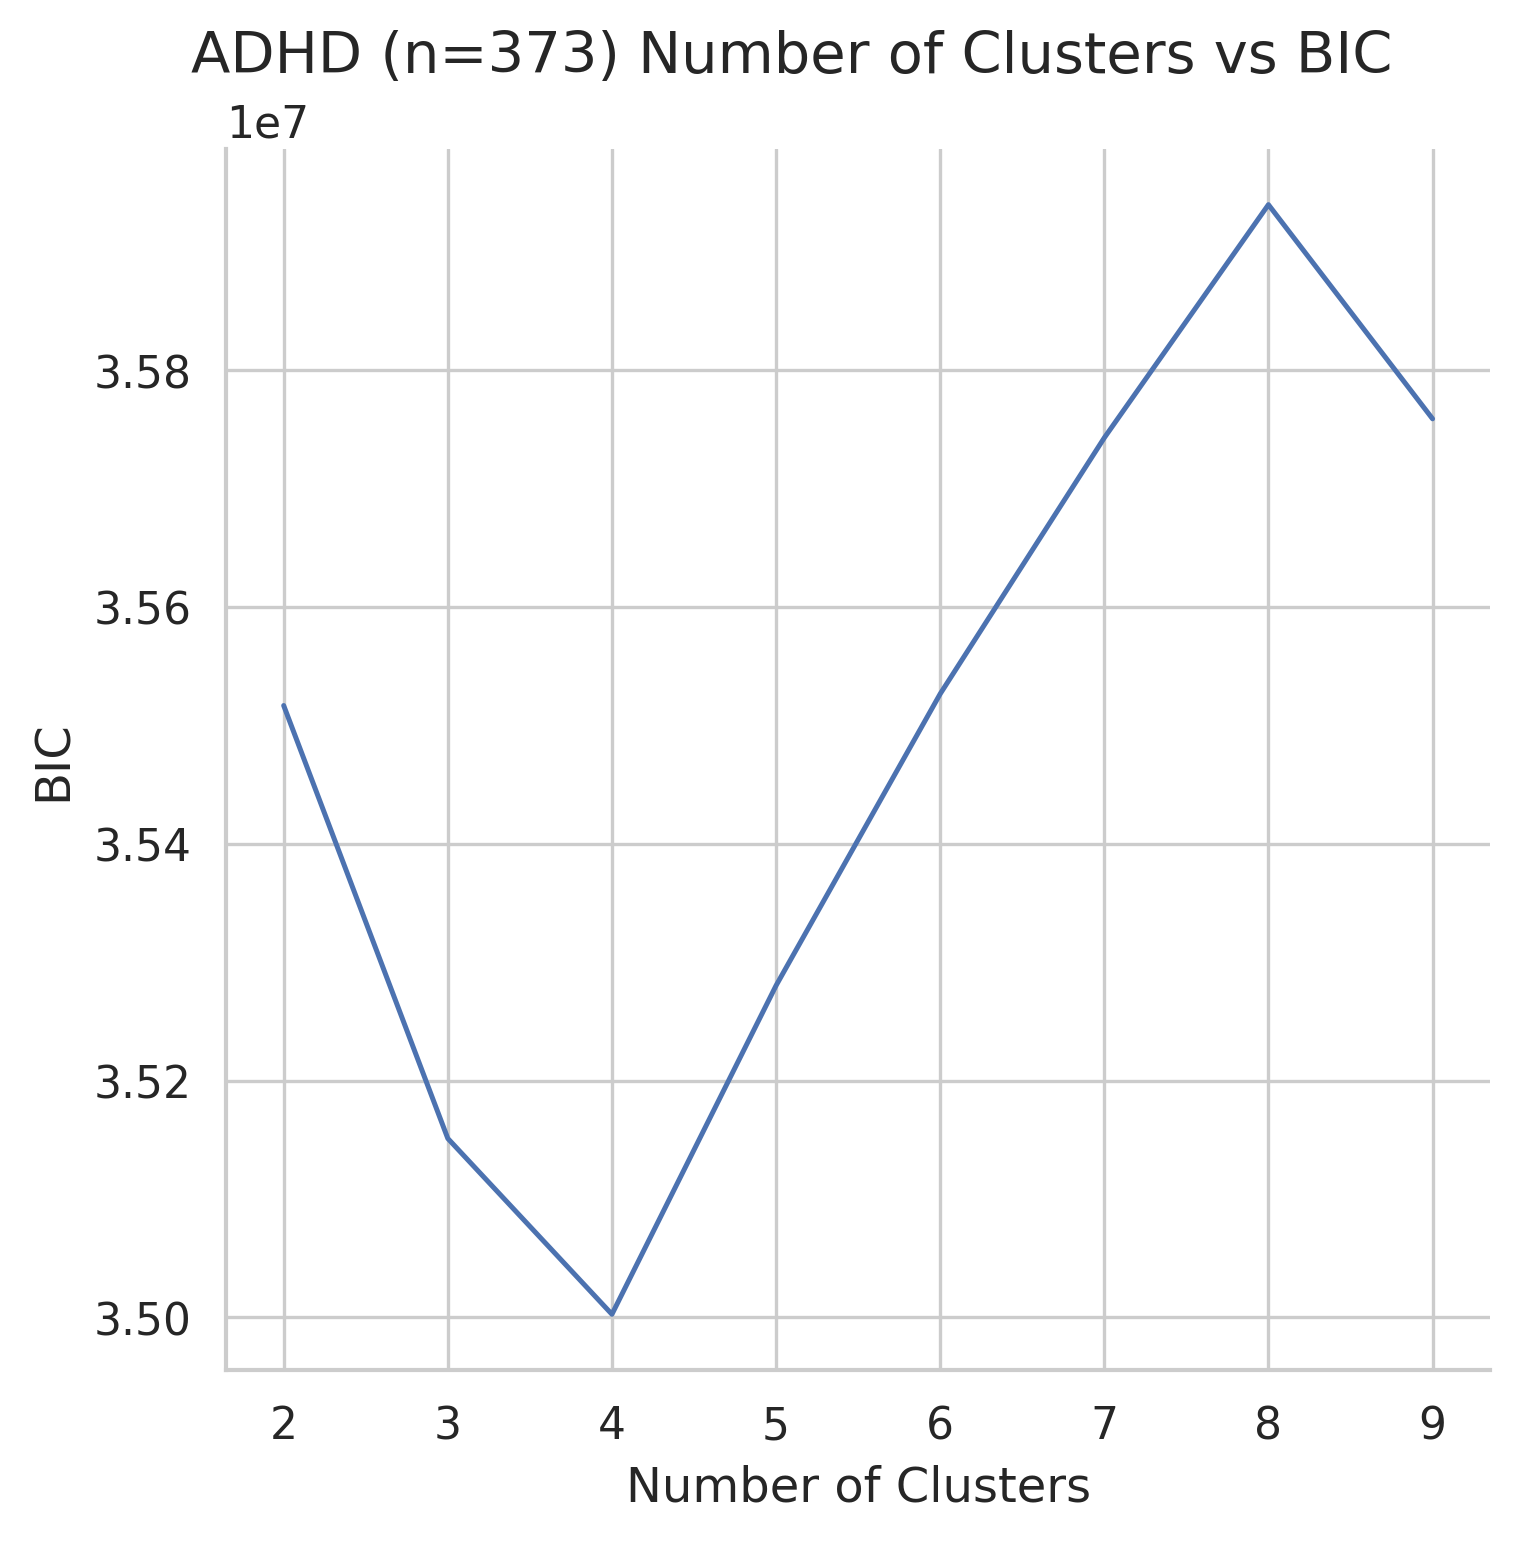

In [18]:
g = sns.relplot(x=range_n_clusters, y=bics, kind="line")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f'ADHD (n={X.shape[0]}) Number of Clusters vs BIC')
g.set_axis_labels('Number of Clusters', 'BIC')

## Run Clustering

In [4]:
X = StandardScaler().fit_transform(X)

### Normal KMeans

In [5]:
clusters = 4
kmeans = KMeans(n_clusters=clusters)
cluster_labels = kmeans.fit_predict(X)

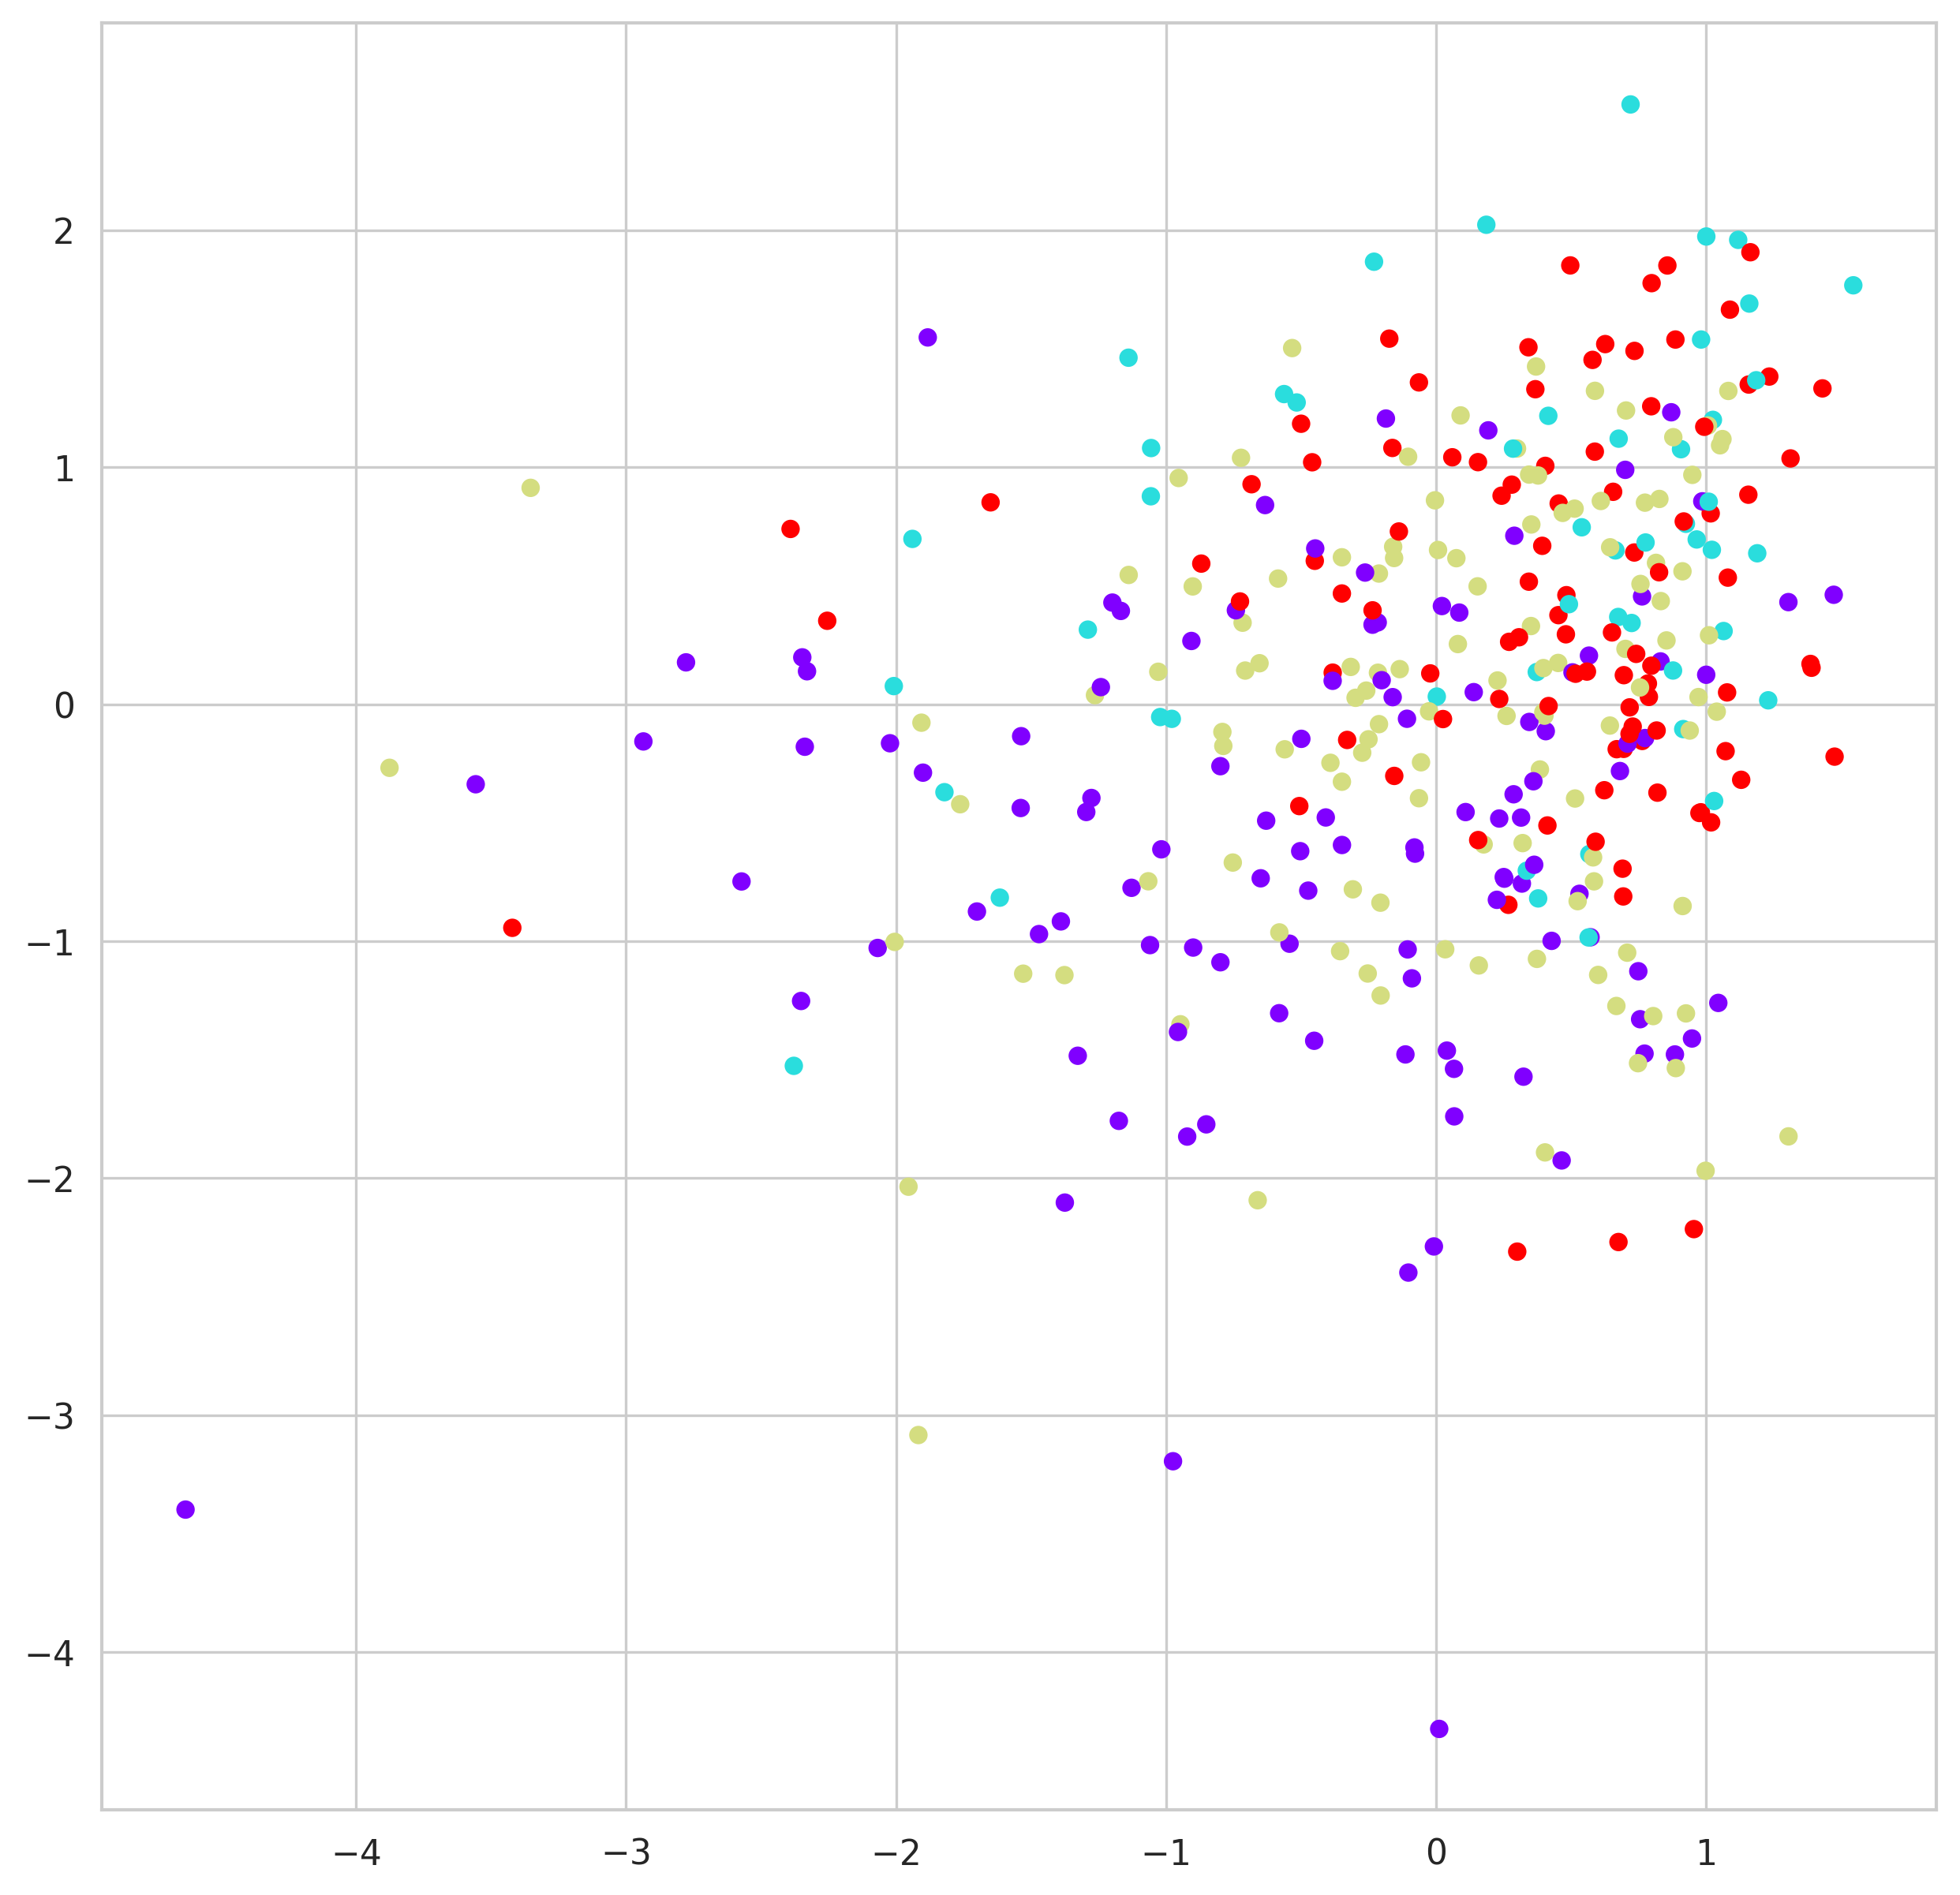

In [6]:
plt.scatter(X[:,0],X[:,1], c=cluster_labels, cmap='rainbow')

### PCA + KMeans

In [6]:
from sklearn.decomposition import PCA

clusters = 4
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)
print(f'PCA explained variance per component: {pca.explained_variance_ratio_}')

kmeans = KMeans(init="k-means++", n_clusters=clusters, n_init=4)
cluster_labels = kmeans.fit_predict(reduced_data.astype('double'))

PCA explained variance per component: [0.19967152 0.03020161]


#### Plot Clusters on PCA-Reduced Data

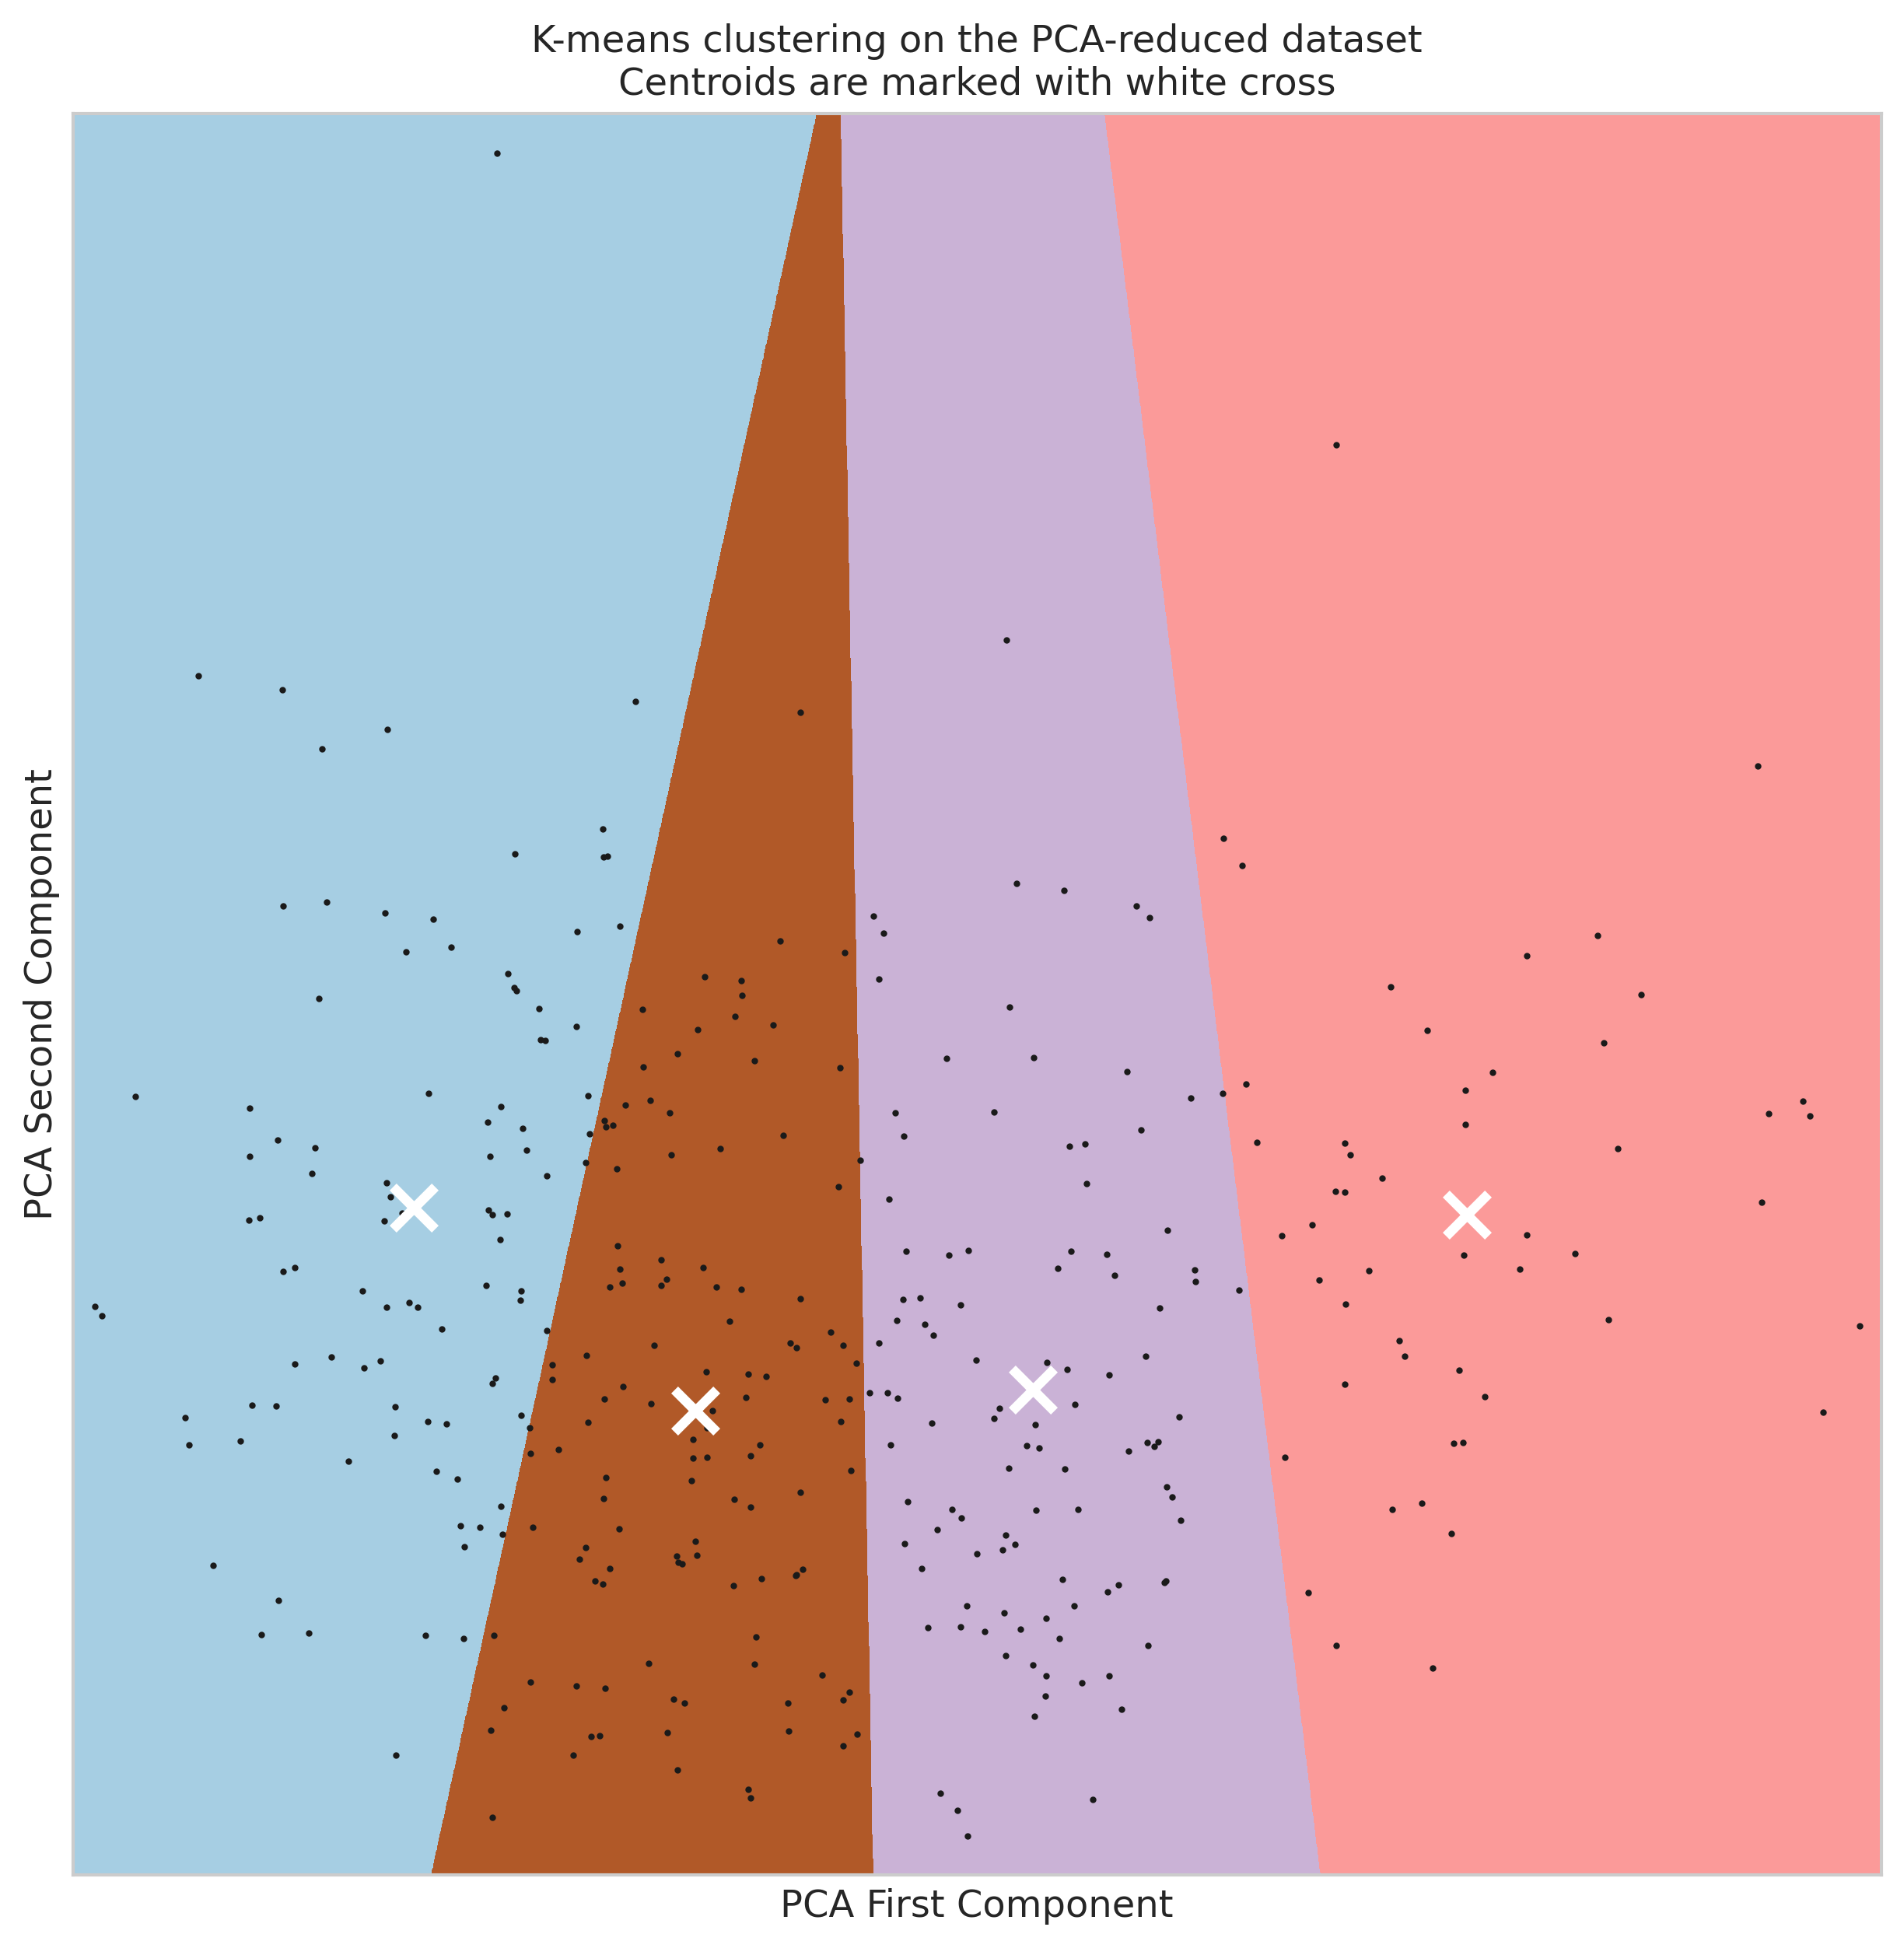

In [5]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired, aspect="auto", origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0], centroids[:, 1], marker="x", s=169,
    linewidths=3, color="w", zorder=10,
)
plt.title(
    "K-means clustering on the PCA-reduced dataset\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.xlabel('PCA First Component')
plt.ylabel('PCA Second Component')
plt.show()

#### Plot PCA Components

In [36]:
print(np.min(pca.components_), np.max(pca.components_))

-0.01710339 0.017320968


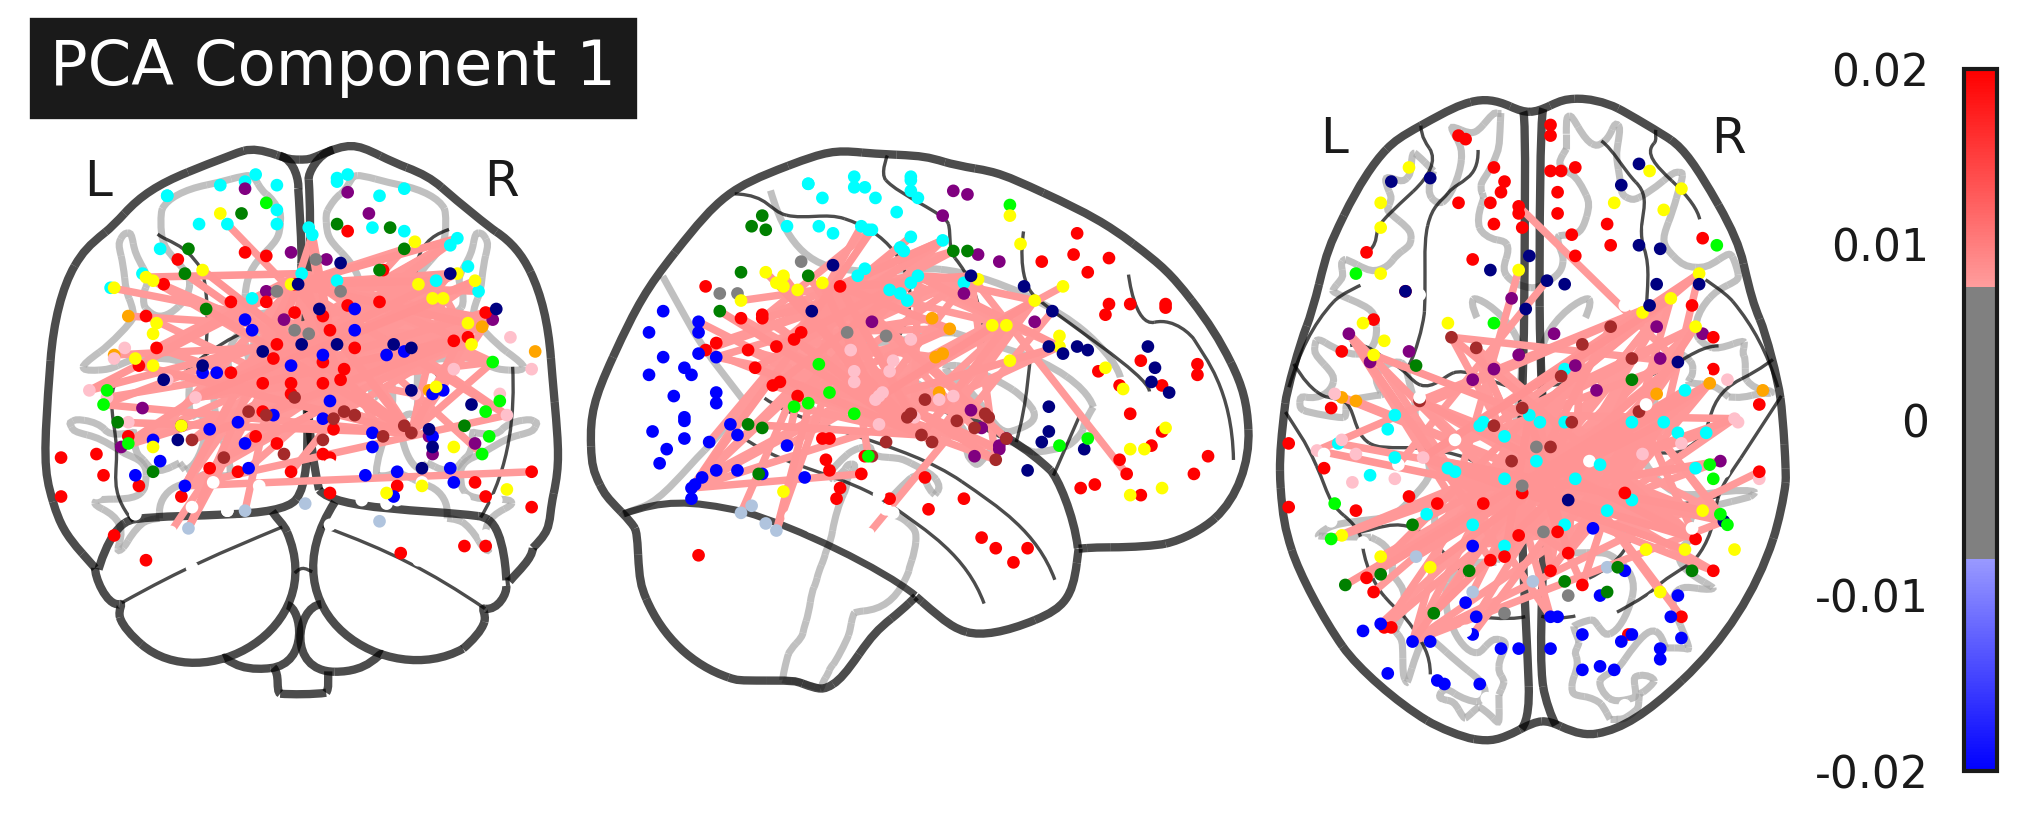

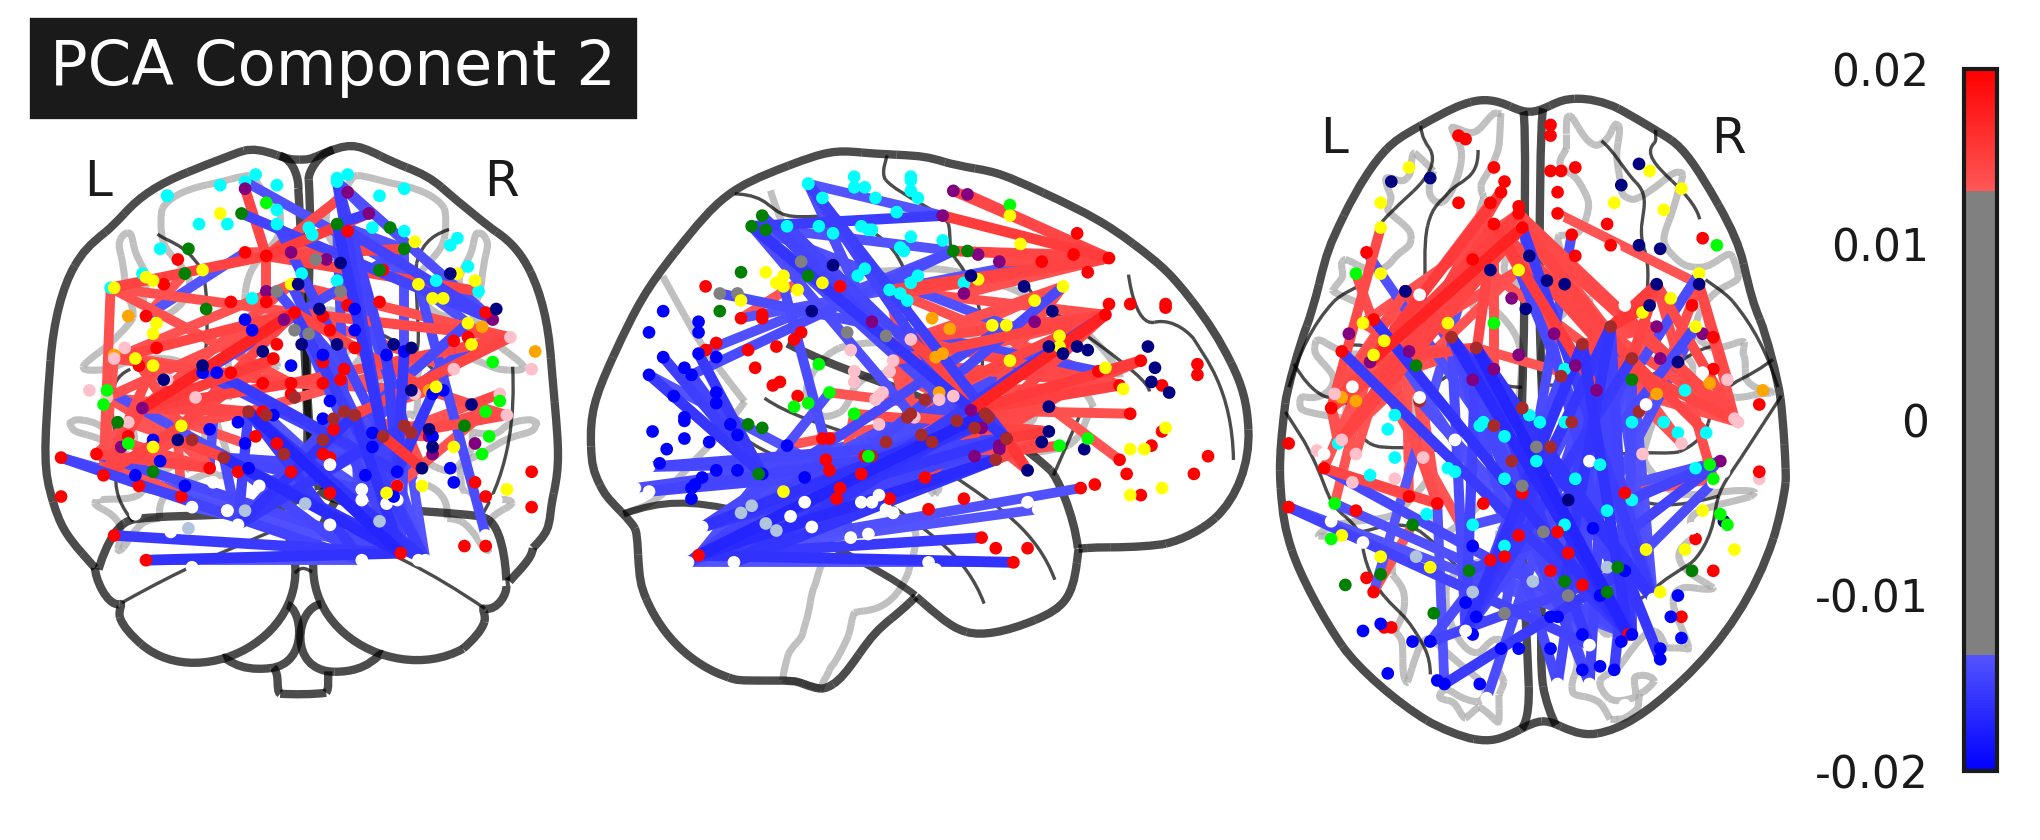

In [45]:
from common.plotting import plot_connections

for num_component, component in enumerate(pca.components_, start=1):
    plot_connections(component, -0.02, 0.02, threshold="99.6%", title=f'PCA Component {num_component}')

#### Plot PCA Explained Variance Graph

In [ ]:
pca = PCA().fit(X)
explained_variances = pca.explained_variance_ratio_[:10]
data = {'Component Num': list(range(1, len(explained_variances) + 1)), 
        'Explained Variance': explained_variances,
        'Cumulative Explained Variance': np.cumsum(explained_variances)
       }
df = pd.DataFrame(data)
df['rank'] = df['Component Num'].rank(method='dense') - 1
# display(df)

bar = sns.barplot(data=df, x='Component Num', y='Explained Variance', palette="rocket")
line = sns.lineplot(data=df, x='rank', y='Cumulative Explained Variance', palette="rocket", drawstyle='steps-pre')
bar.set_title('PCA Explained Variance')

Text(0.5, 1.0, 'PCA Explained Variance')

## Calculate cluster statistics

In [9]:
cluster_indices = []
for cluster in range(0, clusters):
    cluster_index = np.where(cluster_labels == cluster)
    cluster_indices.append(cluster_index)
    print(f'Cluster {cluster} number of samples: {len(cluster_index[0])}')

Cluster 0 number of samples: 89
Cluster 1 number of samples: 113
Cluster 2 number of samples: 118
Cluster 3 number of samples: 53


### Get age and sex stats

In [48]:
ages_clusters = [ages[indices] for indices in cluster_indices]
sexes_clusters = [sexes[indices] for indices in cluster_indices]

for cluster, age_cluster in enumerate(ages_clusters):
    print(f"Cluster {cluster} Age: {np.mean(age_cluster):.2f} ({np.std(age_cluster):.2f})")

print("---")
    
for cluster, sex_cluster in enumerate(sexes_clusters):
    label, counts = np.unique(sex_cluster, return_counts=True)
    print(f"Cluster {cluster} Sex: M={counts[0]} F={counts[1]}")

Cluster 0 Age: 9.80 (2.44)
Cluster 1 Age: 11.05 (2.35)
Cluster 2 Age: 10.78 (2.60)
Cluster 3 Age: 11.03 (2.42)
---
Cluster 0 Sex: M=91 F=28
Cluster 1 Sex: M=40 F=13
Cluster 2 Sex: M=81 F=27
Cluster 3 Sex: M=62 F=31


### Get WISC scores per cluster

WISC_FSIQ
Cluster 0: 101.91 (15.97)
Cluster 1: 100.23 (16.14)
Cluster 2: 100.31 (17.29)
Cluster 3: 96.49 (14.29)
---
WISC_VSI
Cluster 0: 104.47 (18.18)
Cluster 1: 100.42 (15.47)
Cluster 2: 103.59 (18.12)
Cluster 3: 99.92 (15.59)
---
WISC_VCI
Cluster 0: 106.54 (16.82)
Cluster 1: 106.41 (16.14)
Cluster 2: 104.06 (15.96)
Cluster 3: 101.81 (12.42)
---
WISC_FRI
Cluster 0: 103.56 (15.28)
Cluster 1: 101.27 (15.90)
Cluster 2: 100.33 (17.17)
Cluster 3: 99.92 (15.65)
---
WISC_WMI
Cluster 0: 99.12 (15.55)
Cluster 1: 98.81 (14.33)
Cluster 2: 98.69 (15.80)
Cluster 3: 96.64 (14.79)
---
WISC_PSI
Cluster 0: 92.45 (15.00)
Cluster 1: 94.18 (15.12)
Cluster 2: 95.37 (15.99)
Cluster 3: 90.70 (14.36)
---


Text(0.5, 1.0, 'KMeans: WISC Box Plot per Cluster')

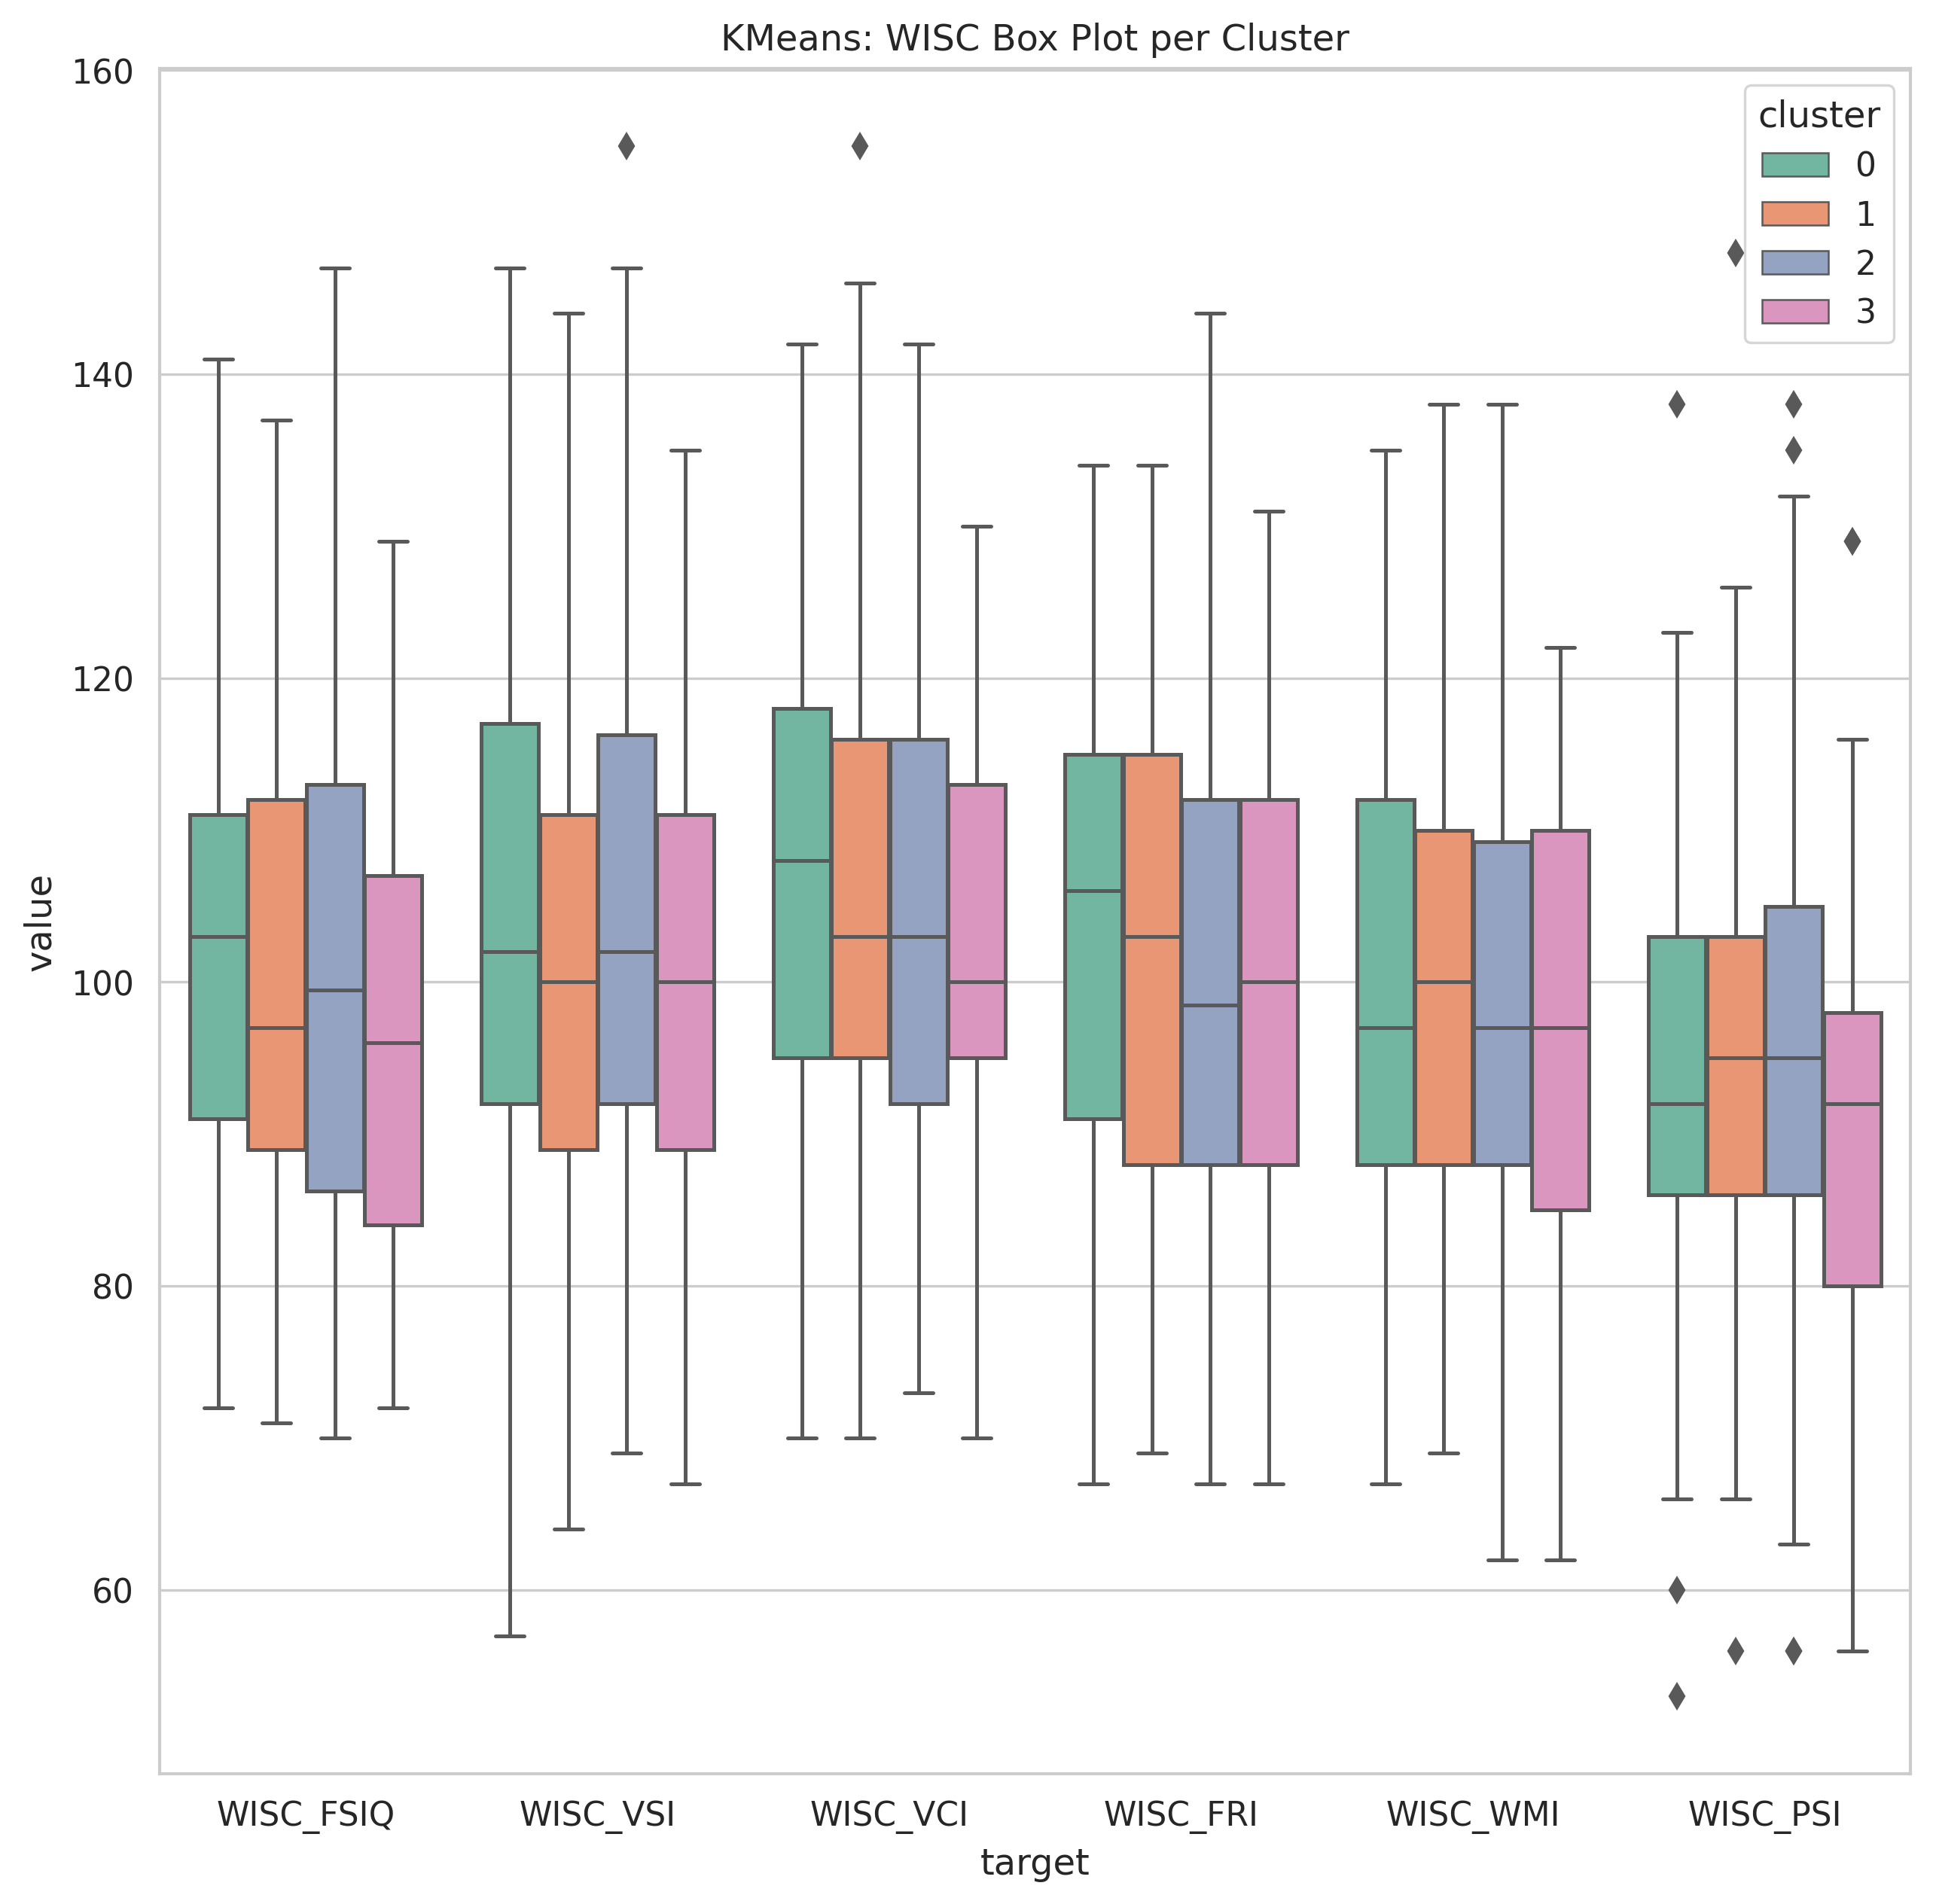

In [10]:
from common.wisc import WISC_LEVEL

data = []

for target in WISC_LEVEL[5]:
    y = Y[target]
    y_clusters = [y[indices] for indices in cluster_indices]
    
    print(target)
    for cluster, y_cluster in enumerate(y_clusters):
        print(f"Cluster {cluster}: {np.mean(y_cluster):.2f} ({np.std(y_cluster):.2f})")
        data += [(cluster, target, value) for value in y_cluster]
    print("---")

data = pd.DataFrame(data, columns=['cluster', 'target', 'value'])
# display(data)

ax = sns.boxplot(x='target', y='value', hue='cluster', data=data, palette="Set2", 
                 order=WISC_LEVEL[5], orient='v')
ax.set_title('KMeans: WISC Box Plot per Cluster')

### Save cluster WISC to CSV

In [25]:
from os.path import join
from common.paths import SCRATCH_DATA


def pad_dict_list(dict_list, padel):
    dict_list_padded = dict_list.copy()
    list_max = np.max([len(l) for l in dict_list.values()])
    
    for k, v in dict_list.items():
        list_len = len(v)
        
        if list_len < list_max:
            dict_list_padded[k] = np.concatenate(
                (dict_list_padded[k], np.full(list_max - list_len, padel)))
    
    return dict_list_padded


csv_data = {}

for target in WISC_LEVEL[5]:
    y = Y[target]
    
    for cluster_num, indices in enumerate(cluster_indices):
        csv_data[f'{target}_cluster_{cluster_num}'] = y[indices]

csv_data = pad_dict_list(csv_data, -1)  ## Fill in missing cells with -1
csv_data = pd.DataFrame(csv_data)
display(csv_data)
filename = 'kmeans_wisc_per_cluster.csv'
csv_data.to_csv(join(SCRATCH_DATA, filename))

,WISC_FSIQ_cluster_0,WISC_FSIQ_cluster_1,WISC_FSIQ_cluster_2,WISC_FSIQ_cluster_3,WISC_VSI_cluster_0,WISC_VSI_cluster_1,WISC_VSI_cluster_2,WISC_VSI_cluster_3,WISC_VCI_cluster_0,WISC_VCI_cluster_1,...,WISC_FRI_cluster_2,WISC_FRI_cluster_3,WISC_WMI_cluster_0,WISC_WMI_cluster_1,WISC_WMI_cluster_2,WISC_WMI_cluster_3,WISC_PSI_cluster_0,WISC_PSI_cluster_1,WISC_PSI_cluster_2,WISC_PSI_cluster_3
0,92,115,120,91,86,102,114,94,108,113,...,103,97,82,117,103,79,100,108,116,100
1,89,97,128,99,86,100,111,108,89,95,...,123,103,97,103,125,107,92,95,119,92
2,75,95,82,126,78,97,81,114,81,106,...,97,121,79,74,79,132,72,103,63,119
3,107,74,86,96,122,86,97,97,108,70,...,91,97,110,88,88,107,77,53,95,83
4,102,97,72,88,108,111,72,94,106,118,...,76,76,79,82,76,65,105,75,98,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,-1,73,-1,-1,-1,86,-1,-1,-1,76,...,-1,-1,-1,76,-1,-1,-1,69,-1,-1
112,-1,87,-1,-1,-1,86,-1,-1,-1,95,...,-1,-1,-1,91,-1,-1,-1,77,-1,-1
113,-1,115,-1,-1,-1,119,-1,-1,-1,142,...,-1,-1,-1,103,-1,-1,-1,72,-1,-1
114,-1,113,-1,-1,-1,144,-1,-1,-1,113,...,-1,-1,-1,100,-1,-1,-1,95,-1,-1
